# Image Classification

<table><tr><td><img src='dataset/1/ILSVRC2012_val_00017995.JPEG'></td><td><img src='dataset/1/ILSVRC2012_val_00024235.JPEG'></td><td><img src='dataset/1/ILSVRC2012_val_00048969.JPEG'></td></tr><tr><td><img src='dataset/2/ILSVRC2012_val_00030520.JPEG'></td><td><img src='dataset/3/ILSVRC2012_val_00025647.JPEG'></td><td><img src='dataset/3/ILSVRC2012_val_00032595.JPEG'></td></tr></table>

In [31]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import intel_pytorch_extension as ipex
import time
import matplotlib.pyplot as plt

DATA='/home/u48334/AI_analytics/dataset'
torch.manual_seed(10)

def run(IPEX):
    bs = 3
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((500, 400)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = torchvision.datasets.ImageFolder(
            root=DATA,
            transform=transform,
    )
    loader = Data.DataLoader(
            dataset=dataset,
            batch_size=bs
    )

    net = torchvision.models.resnet50(pretrained=True)
    net.eval()
    if IPEX:
        net = net.to(ipex.DEVICE)
    num = 0
    dur_sum = 0
    index = 0
    with torch.no_grad():
        for data, target in loader:
            if IPEX:
                data = data.to(ipex.DEVICE)
            for _ in range(10):
                net(data)
            t0 = time.time()
            for _ in range(10):
                net(data)
            t1 = time.time()
            output = net(data)
            _, id_max = torch.max(output, 1)
            for i in range(bs):
                print('{}/{}: {}'.format(index//bs, len(loader), id_max[i]))
            dur_sum += (t1 - t0)/10
            num += data.size()[0]
            index += bs
            #break
    return dur_sum/num*1000.

pytorch version: 1.7.0a0+e85d494
ipex version：   1.2.0
Inference with normal PyTorch
0.0/2: 0
0.0/2: 0
0.0/2: 0
1.0/2: 336
1.0/2: 511
1.0/2: 511
Inference with Intel Extension for PyTorch (IPEX)
0.0/2: 0
0.0/2: 0
0.0/2: 0
1.0/2: 336
1.0/2: 511
1.0/2: 511
Elapsed time (normal): 164.64ms
Elapsed time (ipex):   76.85ms
IPEX achieved 53.32% better performance comparing to normal PyTorch


<BarContainer object of 2 artists>

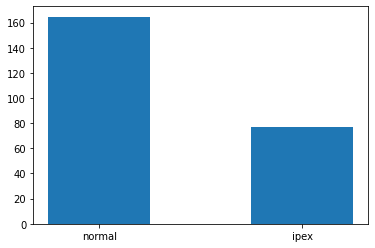

In [32]:
print("pytorch version: {}".format(torch.__version__))
print("ipex version：   {}".format(ipex.__version__))
print("Inference with normal PyTorch")
dur_n = run(False)
print("Inference with Intel Extension for PyTorch (IPEX)")
dur_i = run(True)
print('Elapsed time (normal): {:.2f}ms'.format(dur_n))
print('Elapsed time (ipex):   {:.2f}ms'.format(dur_i))
print('IPEX achieved {:.2f}% better performance comparing to normal PyTorch'.format((dur_n-dur_i)/dur_n*100.))

plt.bar(["normal", "ipex"], [dur_n, dur_i], width=0.5)